# Landuse accessibility from OSM data

Calculate landuse accessibilities from OSM data.

This examples calculates landuse accessibility to pubs and restaurants for London using OpenStreetMap data.


In [1]:
from cityseer.metrics import layers
from cityseer.tools import graphs, io
import matplotlib.pyplot as plt
from osmnx import features

To start, follow the same approach as shown in the network examples to create the network.


In [2]:
lng, lat = -0.13396079424572427, 51.51371088849723
buffer = 1500
poly_wgs, epsg_code = io.buffered_point_poly(lng, lat, buffer)
G = io.osm_graph_from_poly(poly_wgs)
G_dual = graphs.nx_to_dual(G)
nodes_gdf, _edges_gdf, network_structure = io.network_structure_from_nx(G_dual)

INFO:cityseer.tools.graphs:Generating interpolated edge geometries.
INFO:cityseer.tools.io:Converting networkX graph to CRS code 32630.
INFO:cityseer.tools.io:Processing node x, y coordinates.
INFO:cityseer.tools.io:Processing edge geom coordinates, if present.
INFO:cityseer.tools.graphs:Removing filler nodes.
INFO:cityseer.tools.util:Creating edges STR tree.
INFO:cityseer.tools.graphs:Removing filler nodes.
INFO:cityseer.tools.graphs:Removing dangling nodes.
INFO:cityseer.tools.graphs:Removing filler nodes.
INFO:cityseer.tools.util:Creating edges STR tree.
INFO:cityseer.tools.graphs:Splitting opposing edges.
INFO:cityseer.tools.graphs:Squashing opposing nodes
INFO:cityseer.tools.graphs:Merging parallel edges within buffer of 25.
INFO:cityseer.tools.util:Creating edges STR tree.
INFO:cityseer.tools.graphs:Splitting opposing edges.
INFO:cityseer.tools.graphs:Squashing opposing nodes
INFO:cityseer.tools.graphs:Merging parallel edges within buffer of 25.
INFO:cityseer.tools.util:Creating 

Prepare the amenities GeoDataFrame by downloading the data from OpenStreetMap. The `osmnx` [`features_from_polygon`](https://osmnx.readthedocs.io/en/stable/user-reference.html#osmnx.features.features_from_polygon) works well for this purpose. In this instance, we are specifically targeting features that are labelled as an `amenity` type of either `pub` or `restaurant`. You can use the same idea to extract other features or land use types.

It is important to convert the derivative GeoDataFrame to the same CRS as the network.


In [3]:
data_gdf = features.features_from_polygon(
    poly_wgs, tags={"amenity": ["pub", "restaurant"]}
)
data_gdf = data_gdf.to_crs(nodes_gdf.crs)
data_gdf

geometry  \
element id                                                              
node    21593236                       POINT (699869.619 5711280.678)   
        25471087                         POINT (699749.16 5710787.29)   
        25475914                       POINT (699606.322 5711699.239)   
        25746185                         POINT (700308.36 5710758.42)   
        26699558                       POINT (699071.215 5711168.671)   
...                                                               ...   
way     995954627   POLYGON ((699270.101 5710540.727, 699277.571 5...   
        1016903732  POLYGON ((699039.571 5710804.095, 699036.453 5...   
        1060462032  POLYGON ((700144.125 5710144.723, 700142.327 5...   
        1072559143  POLYGON ((699383.906 5710631.863, 699382.376 5...   
        1194233515  POLYGON ((700109.233 5711375.71, 700111.379 57...   

                   addr:city addr:country addr:housenumber addr:postcode  \
element id                                                                 
node    21593236      London           GB               12      WC2A 3HP   
        25471087      London          NaN               39           NaN   
        25475914         NaN          NaN              NaN           NaN   
        25746185      London          NaN              NaN      WC2R 3LD   
        26699558         NaN          NaN              NaN           NaN   
...                      ...          ...              ...           ...   
way     995954627     London          NaN               24      WC2H 0HX   
        1016903732       NaN          NaN              NaN           NaN   
        1060462032    London          NaN              NaN       SE1 8XX   
        1072559143    London          NaN               17      WC2E 9AX   
        1194233515    London          NaN          283-288      WC1V 7HP   

                           addr:street     amenity  check_date  \
element id                                                       
node    21593236           Gate Street         pub  2023-04-18   
        25471087            Bow Street         pub         NaN   
        25475914                   NaN         pub         NaN   
        25746185                   NaN         pub         NaN   
        26699558                   NaN         pub  2024-09-10   
...                                ...         ...         ...   
way     995954627   Charing Cross Road  restaurant  2024-10-07   
        1016903732                 NaN  restaurant         NaN   
        1060462032      Belvedere Road  restaurant         NaN   
        1072559143      Garrick Street  restaurant         NaN   
        1194233515        High Holborn         pub  2023-08-03   

                               contact:email     contact:phone  ...  \
element id                                                      ...   
node    21593236    info@theshiptavern.co.uk  +44 20 7405 1992  ...   
        25471087                         NaN               NaN  ...   
        25475914                         NaN               NaN  ...   
        25746185                         NaN               NaN  ...   
        26699558                         NaN               NaN  ...   
...                                      ...               ...  ...   
way     995954627                        NaN               NaN  ...   
        1016903732                       NaN               NaN  ...   
        1060462032                       NaN               NaN  ...   
        1072559143                       NaN  +44 20 3675 0930  ...   
        1194233515                       NaN  +44 20 7242 5669  ...   

                   access:conditional note:access name:gsw note:name:en  \
element id                                                                
node    21593236                  NaN         NaN      NaN          NaN   
        25471087                  NaN         NaN      NaN          NaN   
        25475914                  NaN  

Some preparatory data cleaning is typically necessary. This example extracts the particular rows and columns of interest for the subsequent steps of analysis.


In [4]:
# extract nodes
data_gdf = data_gdf.loc["node"]
# reset index
data_gdf = data_gdf.reset_index(level=0, drop=True)
# extract relevant columns
data_gdf = data_gdf[["amenity", "geometry"]]
data_gdf.head()

,amenity,geometry
0,pub,POINT (699869.619 5711280.678)
1,pub,POINT (699749.16 5710787.29)
2,pub,POINT (699606.322 5711699.239)
3,pub,POINT (700308.36 5710758.42)
4,pub,POINT (699071.215 5711168.671)


Once the land use and network data has been prepared, use the [`layers.compute_accessibilities`](https://cityseer.benchmarkurbanism.com/metrics/layers#compute-accessibilities) method to compute accessibilities to land uses. The `landuse_column_label` and the target accessibility keys should correspond to the data in the input GeoDataFrame.


In [5]:
# compute pub accessibility
distances = [100, 200, 400, 800]
nodes_gdf, data_gdf = layers.compute_accessibilities(
    data_gdf,
    landuse_column_label="amenity",
    accessibility_keys=["pub", "restaurant"],
    nodes_gdf=nodes_gdf,
    network_structure=network_structure,
    distances=distances,
)

INFO:cityseer.metrics.layers:Computing land-use accessibility for: pub, restaurant
INFO:cityseer.metrics.layers:Assigning data to network.
INFO:cityseer.data:Assigning 701 data entries to network nodes (max_dist: 100).
INFO:cityseer.data:Collected 1173 potential node assignments from data entries.
INFO:cityseer.data:Finished assigning data. 1173 assignments added to 704 nodes.
INFO:cityseer.graph:Barriers unset and R-tree cleared.
INFO:cityseer.config:Metrics computed for:
INFO:cityseer.config:Distance: 100m, Beta: 0.04, Walking Time: 1.25 minutes.
INFO:cityseer.config:Distance: 200m, Beta: 0.02, Walking Time: 2.5 minutes.
INFO:cityseer.config:Distance: 400m, Beta: 0.01, Walking Time: 5.0 minutes.
INFO:cityseer.config:Distance: 800m, Beta: 0.005, Walking Time: 10.0 minutes.


The output columns are named `cc_{key}_{distance}_{type}`. Where the keys will correspond to the input accessibility keys and the distances will correspond to the input distances. The types will correspond to either non-weighted `nw` or distance weighted `wt` count, or else the distance to the nearest instance of a given landuse.

Standard GeoPandas functionality can be used to explore, visualise, or save the results.


In [6]:
nodes_gdf.columns

Index(['ns_node_idx', 'x', 'y', 'live', 'weight', 'primal_edge',
       'primal_edge_node_a', 'primal_edge_node_b', 'primal_edge_idx',
       'dual_node', 'cc_pub_100_nw', 'cc_pub_100_wt', 'cc_pub_200_nw',
       'cc_pub_200_wt', 'cc_pub_400_nw', 'cc_pub_400_wt', 'cc_pub_800_nw',
       'cc_pub_800_wt', 'cc_pub_nearest_max_800', 'cc_restaurant_100_nw',
       'cc_restaurant_100_wt', 'cc_restaurant_200_nw', 'cc_restaurant_200_wt',
       'cc_restaurant_400_nw', 'cc_restaurant_400_wt', 'cc_restaurant_800_nw',
       'cc_restaurant_800_wt', 'cc_restaurant_nearest_max_800'],
      dtype='object')

(np.float64(697035.8123208123),
 np.float64(700647.6928482385),
 np.float64(5709134.052621752),
 np.float64(5712638.694212982))

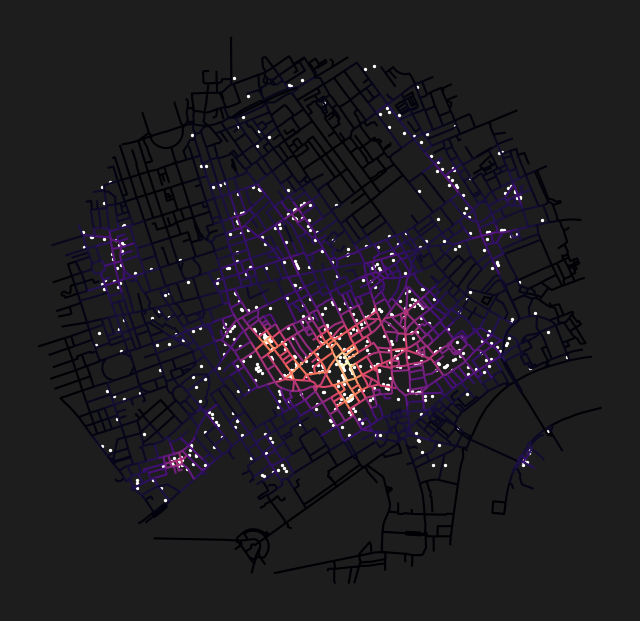

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8), facecolor="#1d1d1d")
nodes_gdf.plot(
    column="cc_restaurant_400_wt",
    cmap="magma",
    legend=False,
    ax=ax,
)
data_gdf[data_gdf["amenity"] == "restaurant"].plot(
    markersize=2,
    edgecolor=None,
    color="white",
    legend=False,
    ax=ax,
)
ax.axis(False)


(np.float64(697035.8123208123),
 np.float64(700647.6928482385),
 np.float64(5709196.42405734),
 np.float64(5712635.724144622))

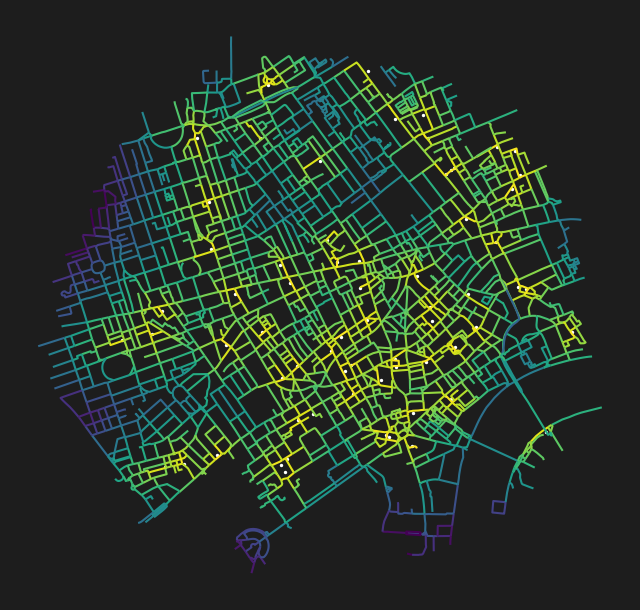

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8), facecolor="#1d1d1d")
nodes_gdf.plot(
    column="cc_pub_nearest_max_800",
    cmap="viridis_r",
    legend=False,
    ax=ax,
)
data_gdf[data_gdf["amenity"] == "pub"].plot(
    markersize=2,
    edgecolor=None,
    color="white",
    legend=False,
    ax=ax,
)
ax.axis(False)